## 2012.1.1 - 2017.9.2 Baltimore Victim-Based Crime exploratory data analysis


In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

In [2]:
# read in kaggle 2012-2017 dataset
df = pd.read_csv("Resources/2012-2017_BPD_Victim_Based_Crime_Data.csv")
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1


## Data cleaning and preparation

Post and CrimeCode dropped. Inside/Ouside cleaned. "Time of Day" and "Day of Week" series added. No null values have been dropped (for example, there are 10,000 nulls in "Inside/Outside", or 3% of the data). 


In [3]:
# data cleaning and organization

# remove series
df.drop(columns=["CrimeCode", "Post"], inplace=True)

# consolidate Inside/Outside values, merging "O" and "I" with "Outside" and "Inside"
df["Inside/Outside"] = df["Inside/Outside"].replace({"Outside": "O", "Inside": "I"})

# convert day to datetime data type
df.CrimeDate = pd.to_datetime(df.CrimeDate)

# change midnight for to_datetime
# create temp series CrimeTimeTemp for splitting data into Time of Day
df.loc[df.CrimeTime == "24:00:00", "CrimeTime"] = "00:00:00"
df["CrimeTimeTemp"] = pd.to_datetime(df.CrimeTime, format="%H:%M:%S")

# create bins and labels for morning, afternoon, evening, late night
# -1 because it kept populating "Time of Day" with NaN for any 0 hours (12am)
bins = [-1, 6, 12, 18, 24]
labels = ["Late Night", "Morning", "Afternoon", "Evening"]

# pd.cut likes ints, so dt.hour extracts the hour for comparison with bins
# remove CrimeTimeTemp from the df
df["Time of Day"] = pd.cut(
    df.CrimeTimeTemp.dt.hour, bins=bins, labels=labels
)
df.drop(columns=["CrimeTimeTemp"], inplace=True)

# add 'Day of Week' series
df["Day of Week"] = df["CrimeDate"].dt.day_name()


In [4]:
df

,CrimeDate,CrimeTime,Location,Description,Inside/Outside,Weapon,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,Time of Day,Day of Week
0,2017-09-02,23:30:00,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,Evening,Saturday
1,2017-09-02,23:00:00,800 NEWINGTON AVE,AUTO THEFT,O,NaN,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,Evening,Saturday
2,2017-09-02,22:53:00,600 RADNOR AV,SHOOTING,O,FIREARM,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1,Evening,Saturday
3,2017-09-02,22:50:00,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,Evening,Saturday
4,2017-09-02,22:31:00,100 LIGHT ST,COMMON ASSAULT,O,HANDS,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,Evening,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276524,2012-01-01,00:00:00,1400 JOH AVE,LARCENY,I,NaN,SOUTHWESTERN,Violetville,-76.67195,39.26132,"(39.2613200000, -76.6719500000)",OTHER - IN,1,Late Night,Sunday
276525,2012-01-01,00:00:00,5500 SINCLAIR LN,LARCENY,O,NaN,NORTHEASTERN,Frankford,-76.53829,39.32493,"(39.3249300000, -76.5382900000)",OTHER - OU,1,Late Night,Sunday
276526,2012-01-01,00:00:00,400 N PATTERSON PK AV,LARCENY,O,NaN,EASTERN,CARE,-76.58497,39.29573,"(39.2957300000, -76.5849700000)",STREET,1,Late Night,Sunday
276527,2012-01-01,00:00:00,5800 LILLYAN AV,BURGLARY,I,NaN,NORTHEASTERN,Glenham-Belhar,-76.54578,39.34701,"(39.3470100000, -76.5457800000)",APT. LOCKE,1,Late Night,Sunday


## Initial visualizations

In [6]:
# pie chart of types of victim-based crime

#create temporary data frame of value counts for types of crime
desc_df = df.Description.value_counts()
desc_df = desc_df.to_frame().reset_index()
desc_df.rename(columns={'index': 'Description', 'Description': 'count'}, inplace=True)

# condense small values into a single 'Other' category
small_values = (desc_df['count'] /len(df)) < .05
desc_df.loc[small_values, 'Description'] = 'Other'
desc_df = desc_df.groupby('Description')['count'].sum()

# plot the pie chart
plt.pie(
    desc_df.values,
    labels=desc_df.index,
    explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Types of Violent Crime")

# add a donut hole to the pie chart
# gcf - get current figure, gca - get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

## Question - Crime by Hour vs various indicators

    Katie - scatter plot of crime by Hour, add a line for each day of the week

    Bryan - line chart of number of crimes per year, categorized by time of day (late night, morning, afternoon, evening)

    Siobhan - rework Katie's scatter plot of crime by hour to make a line for each description of crime
    
    statistical test (ANOVA, t-test, or chi-square)

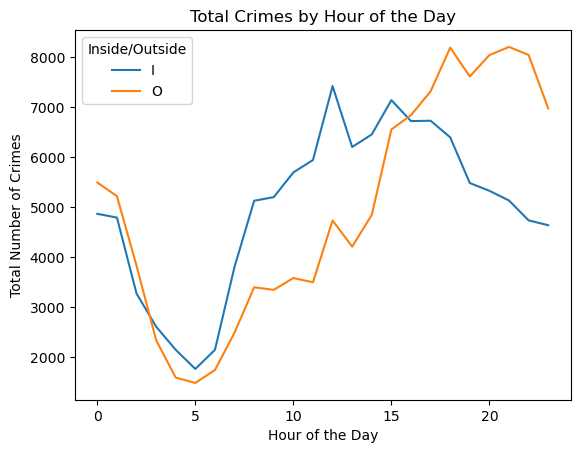

In [6]:
# temporary data frame
pre2017_df = df[df["CrimeDate"].dt.year < 2017].copy()
pre2017_df["CrimeTimeTemp"] = pd.to_datetime(pre2017_df.CrimeTime, format="%H:%M:%S")

# unstack pivots the table
_ = pre2017_df.groupby([pre2017_df["CrimeTimeTemp"].dt.hour, "Inside/Outside"]).size().unstack()

# plot the chart
# need to remove warning
_.plot(kind='line')
plt.title("Total Crimes by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Number of Crimes")
plt.show()

In [7]:
# ANOVA! time of day does not impact crime level in/out
m = df[df["Time of Day"] == "Morning"].groupby(df["Inside/Outside"]).size()
a = df[df["Time of Day"] == "Afternoon"].groupby(df["Inside/Outside"]).size()
e = df[df["Time of Day"] == "Evening"].groupby(df["Inside/Outside"]).size()
n = df[df["Time of Day"] == "Late Night"].groupby(df["Inside/Outside"]).size()

print(f"""{st.f_oneway(m, a, e, n)}
Time has no statistical impact on the difference between crime indoors and outdoors""")

F_onewayResult(statistic=2.5018363212325165, pvalue=0.19835815971583926)
Time has no statistical impact on the difference between crime indoors and outdoors


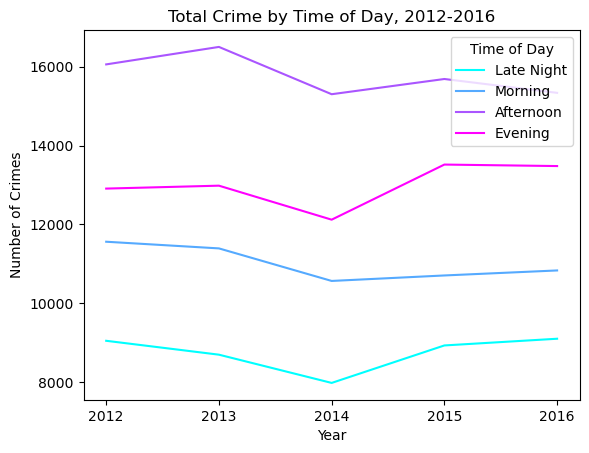

In [8]:
# temporary data frame dropping 2017 (which ends September 2nd, skewing totals)
pre2017_df = df[df.CrimeDate.dt.year < 2017]

# unstack pivots the table
x = pre2017_df.groupby([pre2017_df.CrimeDate.dt.year, "Time of Day"]).size().unstack()

x.plot(kind='line', cmap=plt.colormaps.get_cmap("cool"))
plt.title("Total Crime by Time of Day, 2012-2016")
plt.xticks(x.index.astype(int))
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.show()

In [9]:
# ANOVA
pre2017_df = df[df["CrimeDate"].dt.year < 2017]

#group populations by time of day category
m = pre2017_df[pre2017_df["Time of Day"] == "Morning"].groupby(pre2017_df["CrimeDate"].dt.year).size()
a = pre2017_df[pre2017_df["Time of Day"] == "Afternoon"].groupby(pre2017_df["CrimeDate"].dt.year).size()
e = pre2017_df[pre2017_df["Time of Day"] == "Evening"].groupby(pre2017_df["CrimeDate"].dt.year).size()
n = pre2017_df[pre2017_df["Time of Day"] == "Late Night"].groupby(pre2017_df["CrimeDate"].dt.year).size()

print(f"""{st.f_oneway(m, a, e, n)}
Note the extremely small pvalue. Crime is impacted by the time of day""")

F_onewayResult(statistic=181.68417620148915, pvalue=1.4417942015211965e-12)
Note the extremely small pvalue. Crime is impacted by the time of day


## Question - Crime by Day of Week vs various indicators

    Rob - crime by day of week / scatter plot (or line plot) of crime by hour, but with a line for each year

    Rob - crime description by day of week
    
    statistical test (ANOVA, t-test, or chi-square)

## Question - Crime by Year

    Siobhan - ?Stacked? Bar plot of crime Description by year

    Bryan - plot of crime for each year (by month, instead of day - ?mention Freddie Grey?)
    
    statistical test (ANOVA, t-test, or chi-square)

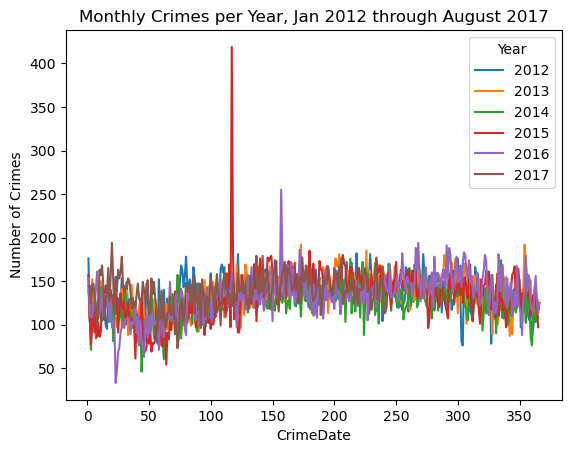

The giant spike in 2015 is the protests following the death of Freddie Gray.

Day 157 of 2016 is 5 June 2016, according to the internet.
But further research is needed to find out what happened around that day.


In [10]:
# huge outlier - Freddie Gray
import calendar

year_df = df.copy()
year_df["Year"] = year_df.CrimeDate.dt.year
year_df["Month"] = year_df.CrimeDate.dt.month
year_df["Day"] = year_df.CrimeDate.dt.year
year_df = year_df[year_df.CrimeDate < "2017-09-01"]

_ = year_df.groupby(year_df.CrimeDate.dt.dayofyear)["Year"].value_counts().unstack()
_.plot(kind='line')

# Format the plot
plt.ylabel("Number of Crimes")
plt.title("Monthly Crimes per Year, Jan 2012 through August 2017")
plt.show()

print(f"""The giant spike in 2015 is the protests following the death of Freddie Gray.

Day {_[2016].idxmax()} of 2016 is 5 June 2016, according to the internet.
But further research is needed to find out what happened around that day.""")

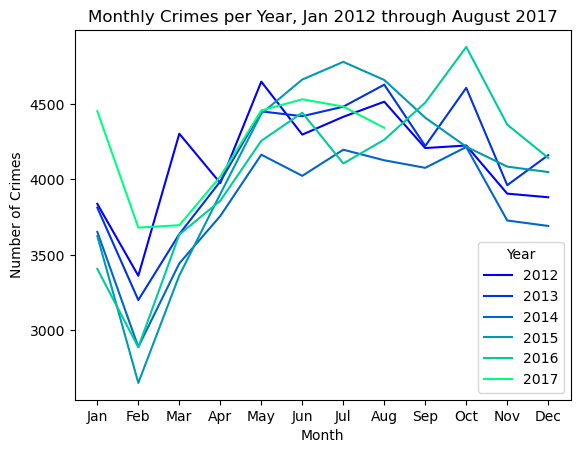

In [11]:
import calendar

year_df = df.copy()
year_df["Year"] = year_df.CrimeDate.dt.year
year_df["Month"] = year_df.CrimeDate.dt.month
year_df = year_df[year_df.CrimeDate < "2017-09-01"]

_ = year_df.groupby("Month")["Year"].value_counts().unstack()
_.plot(kind='line', cmap=plt.colormaps.get_cmap('winter'))

# Format the plot
plt.xticks(range(1, 13), labels=calendar.month_abbr[1:])
plt.ylabel("Number of Crimes")
plt.title("Monthly Crimes per Year, Jan 2012 through August 2017")
plt.show()

In [ ]:
## Crime by Time of Day (a.k.a., most popular morning crime)

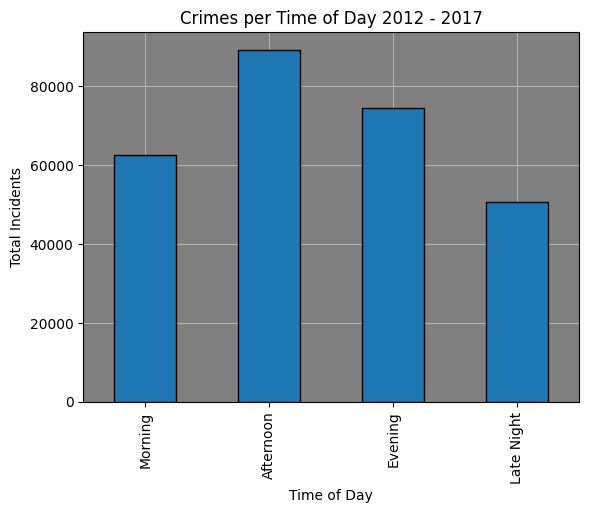

In [7]:
crime_tod = df["Time of Day"].value_counts()
crime_tod = crime_tod.reindex(["Morning", "Afternoon", "Evening", "Late Night"])
crime_tod.plot.bar(edgecolor="black", zorder = 3)
plt.grid()
plt.grid(zorder=0)
plt.title("Crimes per Time of Day 2012 - 2017")
plt.ylabel("Total Incidents")
plt.gca().set_facecolor('grey')


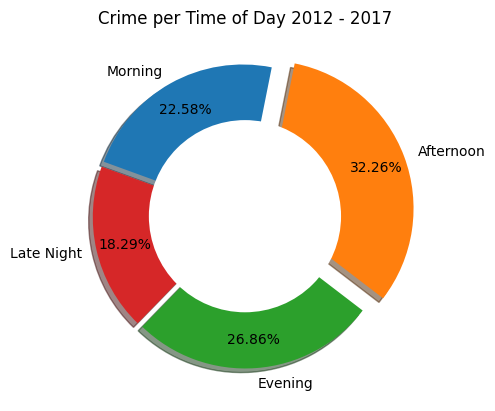

In [8]:
plt.pie(
    crime_tod.values,
    labels=crime_tod.index,
    explode=(0.03, 0.15, 0.03, 0.03),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Crime per Time of Day 2012 - 2017")

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

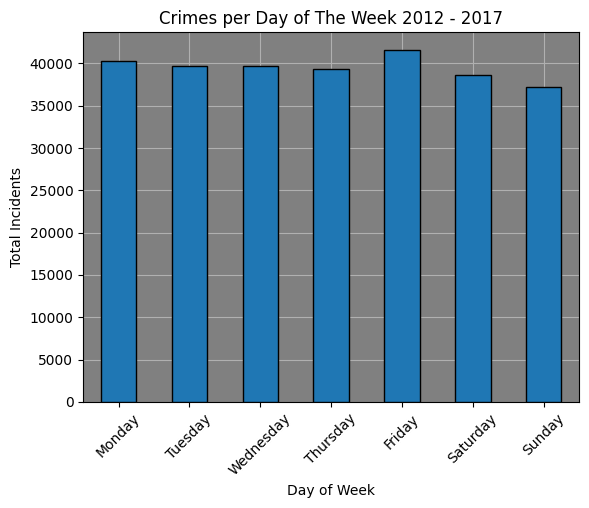

In [9]:
crime_tod = df["Day of Week"].value_counts()
crime_tod = crime_tod.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                                               'Saturday', 'Sunday'])
crime_tod.plot.bar(edgecolor="black", zorder = 3)
plt.title("Crimes per Day of The Week 2012 - 2017")
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.gca().set_facecolor('grey')

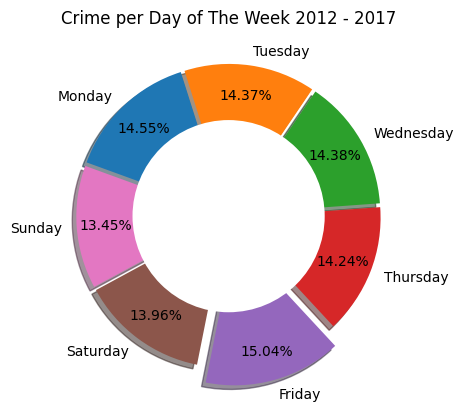

In [10]:
plt.pie(
    crime_tod.values,
    labels=crime_tod.index,
    explode=(0.03, 0.03, 0.03, 0.03, 0.15, 0.03, 0.03),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Crime per Day of The Week 2012 - 2017")

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

In [ ]:
## Breakdown time over years


<Axes: xlabel='CrimeDate'>

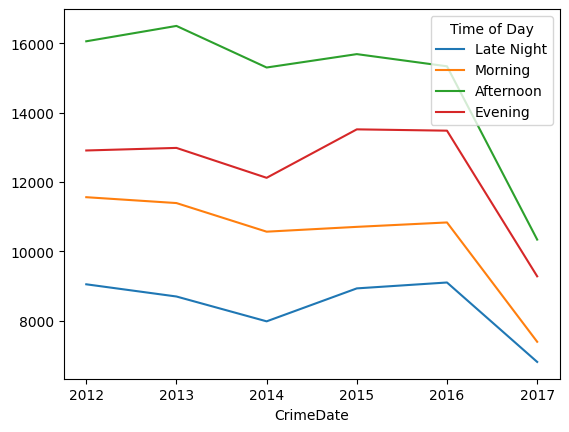

In [11]:
# unstack pivots the table
x = df.groupby([df["CrimeDate"].dt.year, "Time of Day"]).size().unstack()

x.plot(kind='line')

# note that 2017 only contains data for 2/3's of a year (through the beginning of September)

In [12]:
time_of_day = df.groupby([df["CrimeDate"].dt.year, "Time of Day"]).size().unstack()
time_of_day = time_of_day.reindex(columns =["Morning", "Afternoon", "Evening", "Late Night"])
time_of_day

Time of Day,Morning,Afternoon,Evening,Late Night
CrimeDate,,,,
2012,11561,16056,12908,9050
2013,11392,16499,12982,8698
2014,10567,15300,12120,7982
2015,10706,15686,13517,8932
2016,10833,15335,13479,9102
2017,7393,10339,9280,6812


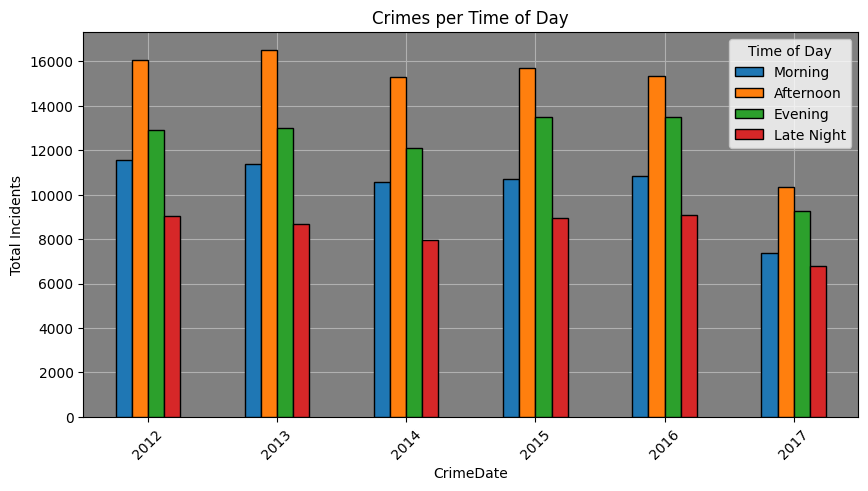

In [13]:
# Plot stacked bar graph
time_of_day.plot(kind="bar", figsize = (10, 5),edgecolor="black", zorder = 3)
plt.title("Crimes per Time of Day")
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.gca().set_facecolor('grey')

In [14]:
day_of_week = df.groupby([df["CrimeDate"].dt.year, "Day of Week"]).size().unstack()
day_of_week = day_of_week.reindex(columns =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                                               'Saturday', 'Sunday'])
day_of_week

Day of Week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
CrimeDate,,,,,,,
2012,7044,6929,7115,6958,7539,7149,6841
2013,7128,7160,7162,7119,7502,6921,6579
2014,6822,6465,6619,6481,6955,6460,6167
2015,7318,7234,6908,7036,7188,6715,6442
2016,7065,7131,7043,6925,7349,6644,6592
2017,4862,4822,4905,4868,5063,4723,4581


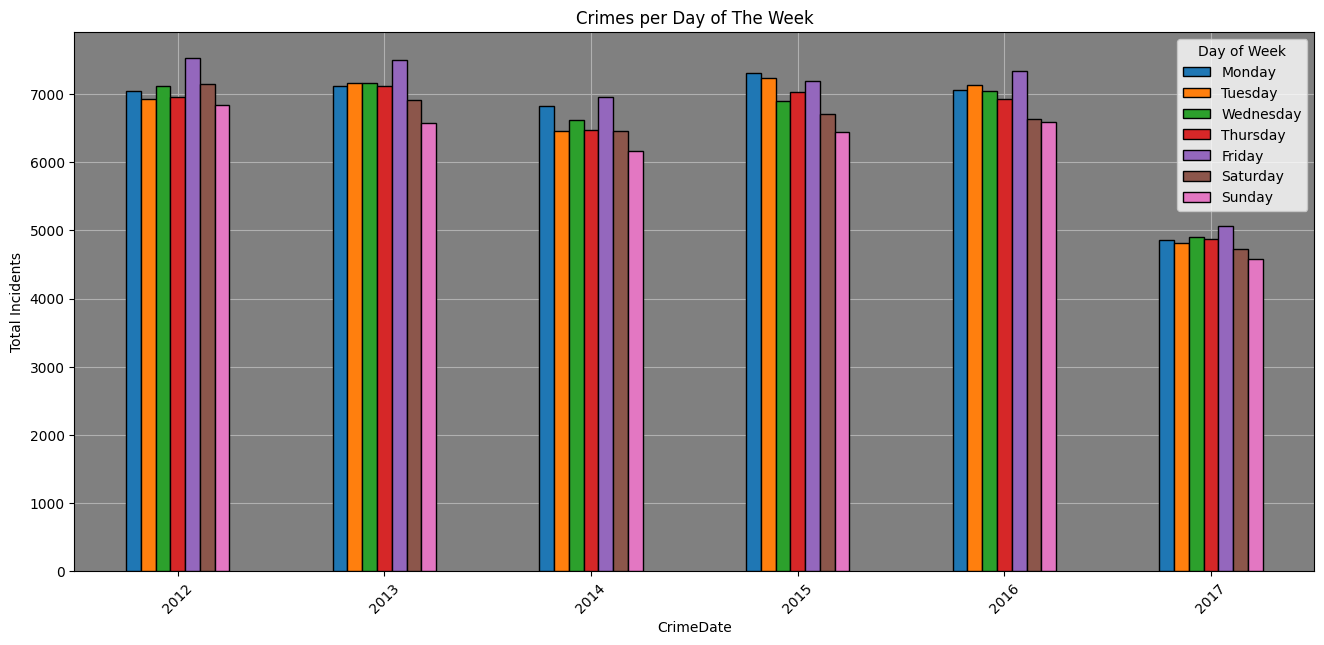

In [15]:
day_of_week.plot(kind="bar", figsize = (16, 7),edgecolor="black", zorder = 3)
plt.title("Crimes per Day of The Week")
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.gca().set_facecolor('grey')

(array([2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.]),
 [Text(2011.0, 0, '2011'),
  Text(2012.0, 0, '2012'),
  Text(2013.0, 0, '2013'),
  Text(2014.0, 0, '2014'),
  Text(2015.0, 0, '2015'),
  Text(2016.0, 0, '2016'),
  Text(2017.0, 0, '2017'),
  Text(2018.0, 0, '2018')])

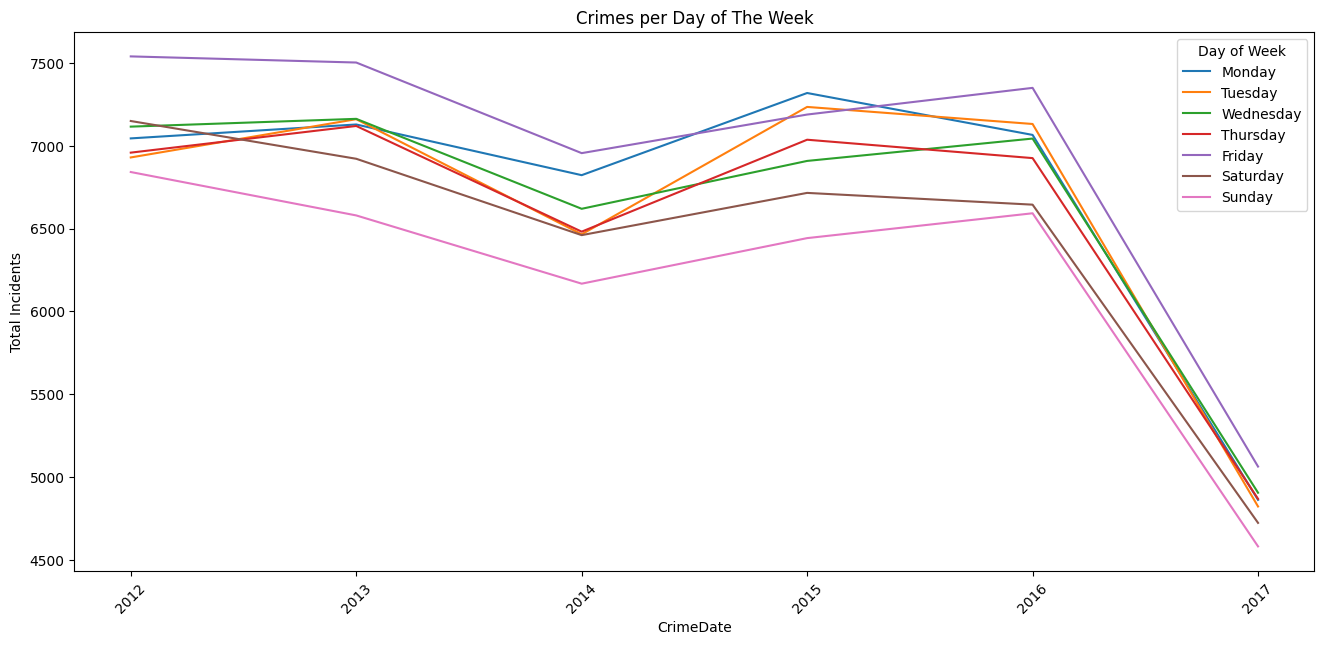

In [16]:
day_of_week.plot(kind="line", figsize = (16, 7))
plt.title("Crimes per Day of The Week")
plt.ylabel("Total Incidents")
#plt.grid()
#plt.grid(zorder=0)
plt.xticks(rotation=45)
#plt.gca().set_facecolor('grey')

In [17]:
crime_dis = df.groupby([df["CrimeDate"].dt.year, "District"]).size().unstack()
crime_dis

District,CENTRAL,EASTERN,NORTHEASTERN,NORTHERN,NORTHWESTERN,SOUTHEASTERN,SOUTHERN,SOUTHWESTERN,WESTERN
CrimeDate,,,,,,,,,
2012,6496,4235,7728,5586,4886,6580,5796,4440,3812
2013,5656,4135,7838,5741,5324,6983,5581,4265,4035
2014,5034,3661,7513,5320,4703,6427,5213,4357,3728
2015,5317,4098,7723,5948,4778,7105,5224,4620,4007
2016,5700,4275,6882,5409,4937,6686,6001,4767,4079
2017,3428,3231,5322,3661,3433,4510,4035,3643,2557


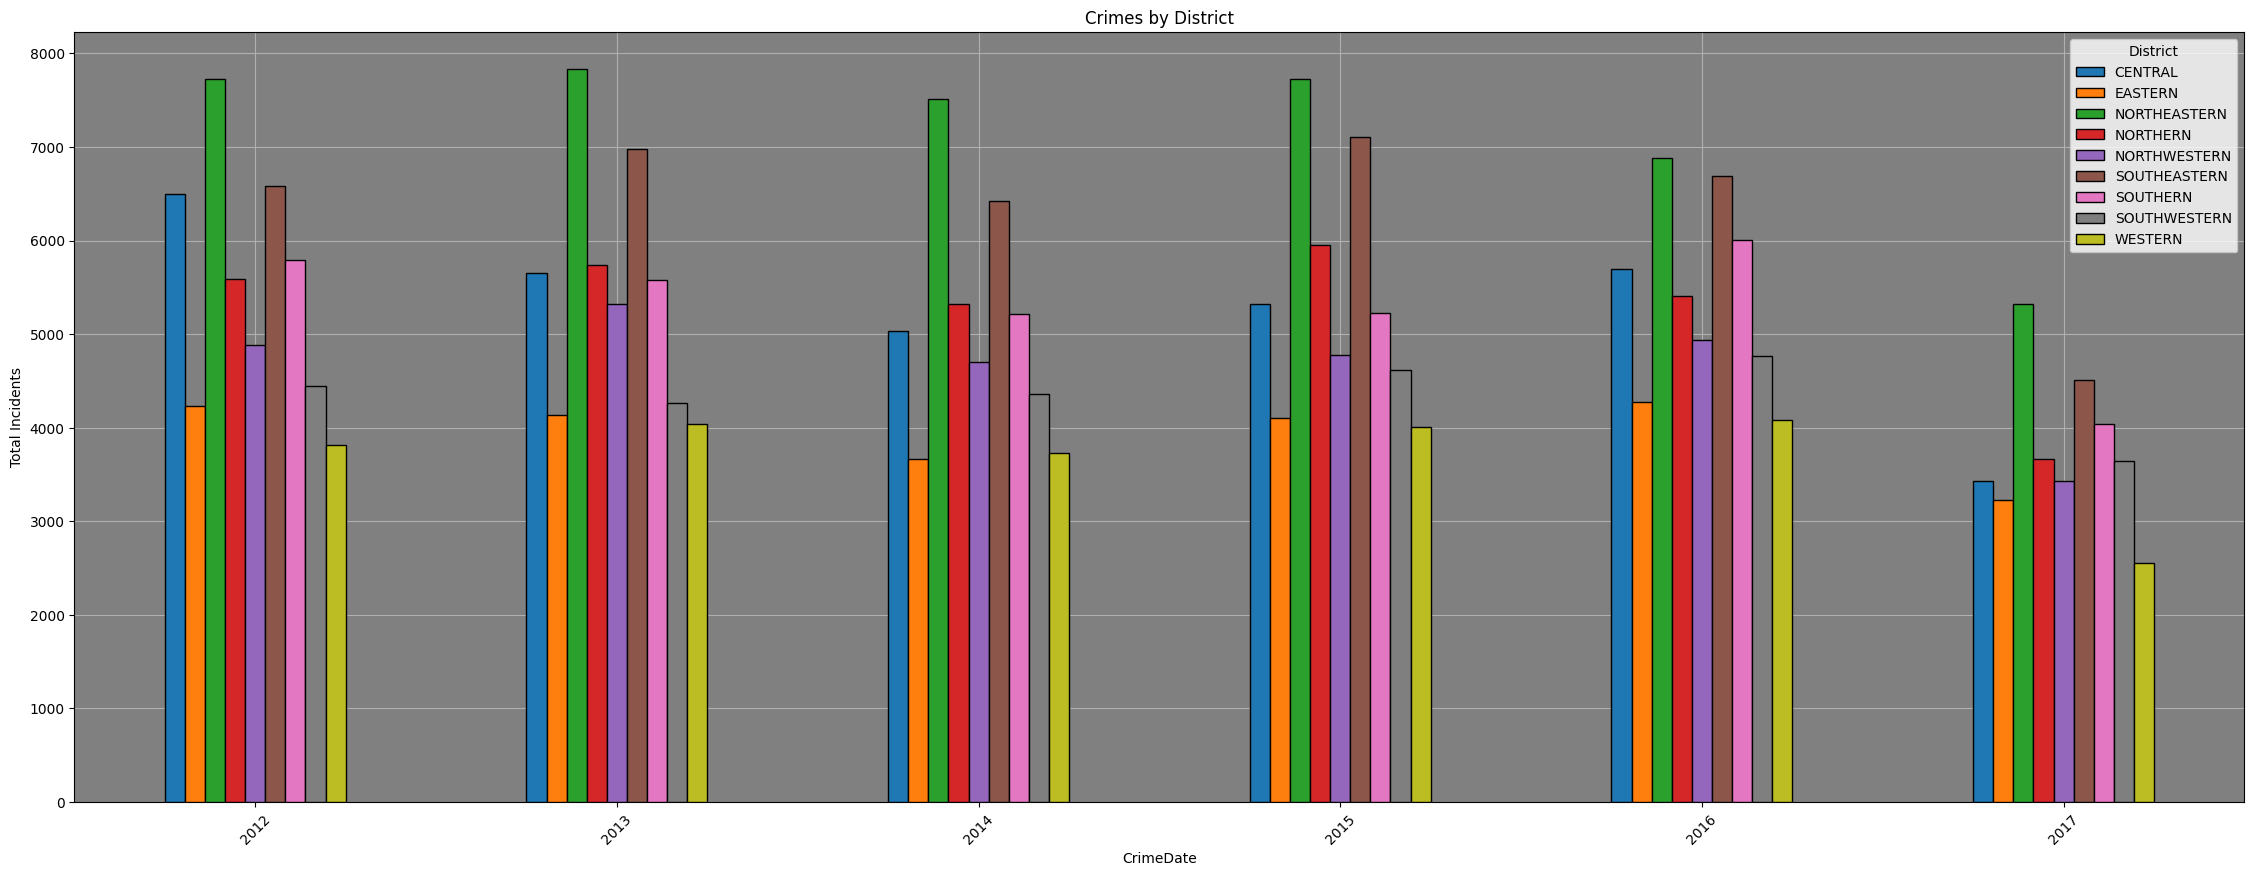

In [18]:
crime_dis.plot(kind="bar", figsize = (28, 10),edgecolor="black", zorder = 3)
plt.title("Crimes by District")
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.gca().set_facecolor('grey')

(array([2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.]),
 [Text(2011.0, 0, '2011'),
  Text(2012.0, 0, '2012'),
  Text(2013.0, 0, '2013'),
  Text(2014.0, 0, '2014'),
  Text(2015.0, 0, '2015'),
  Text(2016.0, 0, '2016'),
  Text(2017.0, 0, '2017'),
  Text(2018.0, 0, '2018')])

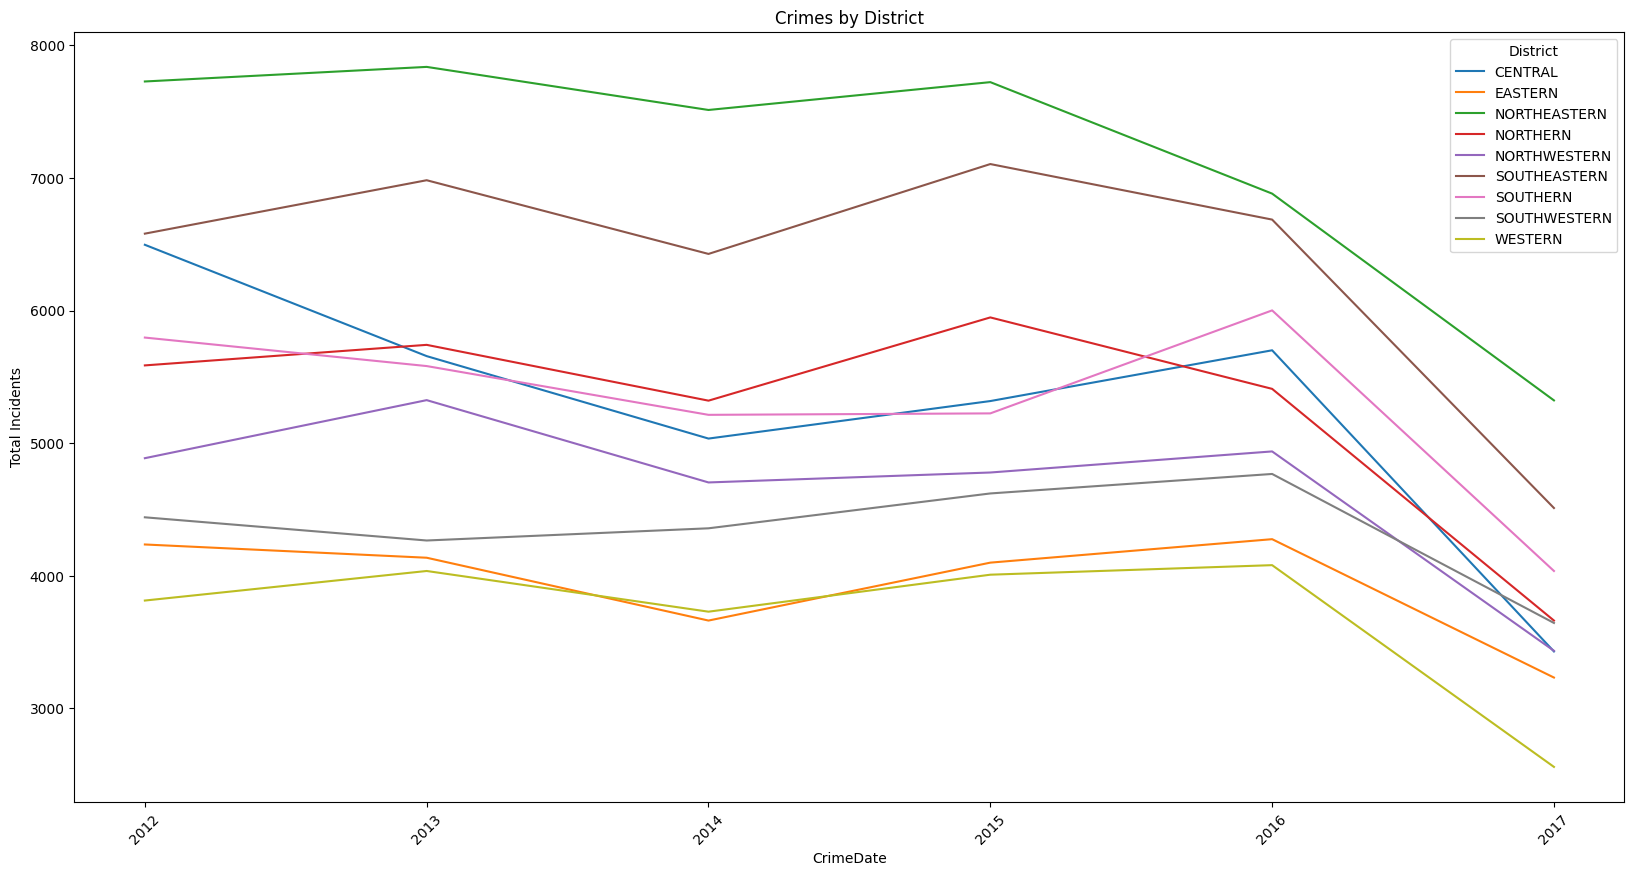

In [29]:
crime_dis.plot(kind="line", figsize = (20, 10))
plt.title("Crimes by District")
plt.ylabel("Total Incidents")
#plt.grid()
#plt.grid(zorder=0)
plt.xticks(rotation=45)
#plt.gca().set_facecolor('grey')

## Statistical Analysis